In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#deepAR
from gluonts.dataset.common import ListDataset

from gluonts.evaluation import make_evaluation_predictions, Evaluator

#neuralProphet
from neuralprophet import NeuralProphet


from darts import TimeSeries
from darts.models import RNNModel, NBEATSModel
from darts.metrics import mape, rmse, mae



from datetime import datetime, timedelta

from statsmodels.tsa.arima.model import ARIMA


In [77]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

##### Daa loading

In [78]:
data_path='c:/Bureau/time series 2 project/data_export/'
tsla_data = pd.read_csv(f"{data_path}tsla_data.csv", parse_dates=['Date'])
train_tesla = pd.read_csv(f"{data_path}tsla_train_data.csv", parse_dates=['Date'])
test_tesla = pd.read_csv(f"{data_path}tsla_test_data.csv", parse_dates=['Date'])


#### data exploration

In [81]:
tsla_data.head()

,Date,Open,High,Low,Close,Volume,Adjusted,Returns,Volume_Change,Price_Range,RSI
0,2020-01-23,37.616669,38.799999,37.040001,38.146667,294765000.0,38.146667,0.004624,-0.467692,0.046138,81.575907
1,2020-01-24,38.042000,38.257332,36.950668,37.654667,215304000.0,37.654667,-0.012981,-0.314127,0.034701,78.789833
2,2020-01-27,36.132668,37.629333,35.952000,37.201332,204121500.0,37.201332,-0.012112,-0.053336,0.045088,76.207187
3,2020-01-28,37.899334,38.453999,37.205334,37.793331,176827500.0,37.793331,0.015788,-0.143541,0.033039,77.255654
4,2020-01-29,38.379333,39.320000,37.828667,38.732666,267022500.0,38.732666,0.024551,0.412158,0.038503,78.848365


WARNING - (py.warnings._showwarnmsg) - C:\Users\lando\AppData\Local\Temp\ipykernel_24544\692230681.py:43: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()

WARNING - (py.warnings._showwarnmsg) - c:\Bureau\time series 2 project\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)



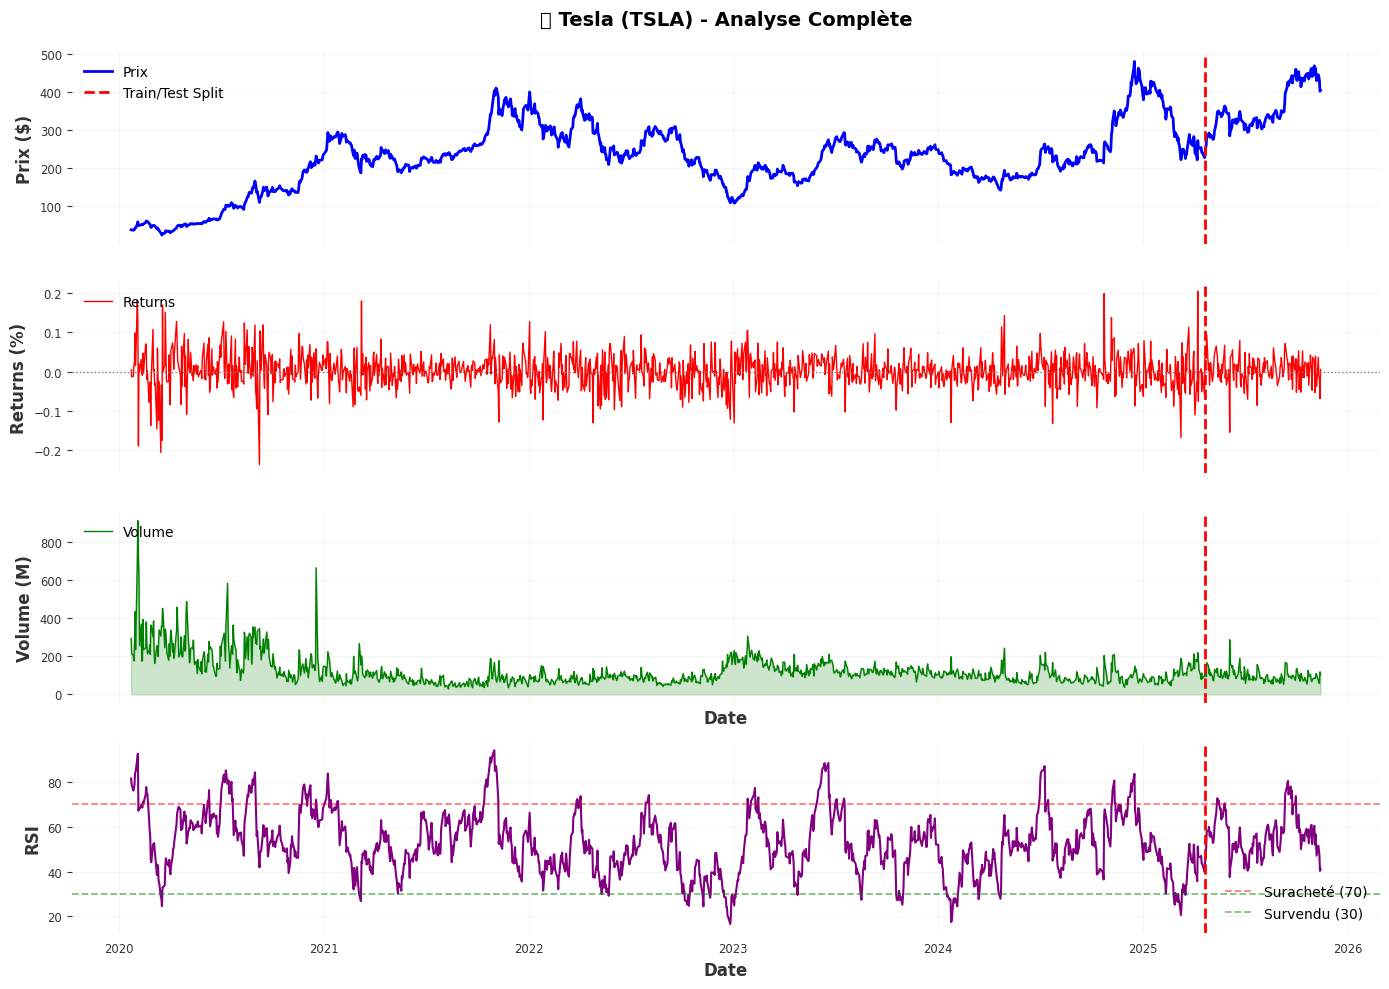

In [82]:

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

split_date = pd.to_datetime(test_tesla['Date'].iloc[0])

# 1. PRIX : 
axes[0].plot(tsla_data['Date'], tsla_data['Close'], color='blue', linewidth=2, label='Prix')
axes[0].axvline(split_date, color='red', linestyle='--', linewidth=2, label='Train/Test Split')
axes[0].set_ylabel('Prix ($)', fontsize=12, fontweight='bold')
axes[0].set_title('📈 Tesla (TSLA) - Analyse Complète', fontsize=14, fontweight='bold', pad=20)
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# 2. RENDEMENTS : 
#  est le changement du prix  d'un jour à un autre en pourcentage
axes[1].plot(tsla_data['Date'], tsla_data['Returns'], color='red', linewidth=1, label='Returns')
axes[1].axvline(split_date, color='red', linestyle='--', linewidth=2)
axes[1].axhline(0, color='gray', linestyle=':', linewidth=1)
axes[1].set_ylabel('Returns (%)', fontsize=12, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

# 3. VOLUME
# volume est le nombre d'actions échangées pendant une période donnée
axes[2].plot(tsla_data['Date'], tsla_data['Volume']/1e6, color='green', linewidth=1, label='Volume')
axes[2].fill_between(tsla_data['Date'], 0, tsla_data['Volume']/1e6, alpha=0.2, color='green')
axes[2].axvline(split_date, color='red', linestyle='--', linewidth=2)
axes[2].set_ylabel('Volume (M)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[2].legend(loc='upper left')
axes[2].grid(True, alpha=0.3)

# 4. RSI 
#est la vitesse et le changement des mouvements de prix
axes[3].plot(tsla_data['Date'], tsla_data['RSI'], color='purple', linewidth=1.5)
axes[3].axhline(70, color='red', linestyle='--', alpha=0.5, label='Suracheté (70)')
axes[3].axhline(30, color='green', linestyle='--', alpha=0.5, label='Survendu (30)')
axes[3].axvline(split_date, color='red', linestyle='--', linewidth=2)
axes[3].set_ylabel('RSI', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()





In [160]:
train_tesla.isna().sum()

Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
Adjusted         0
Returns          0
Volume_Change    0
Price_Range      0
RSI              0
dtype: int64

#### Data processing

In [308]:
from sklearn.preprocessing import StandardScaler
features = ['Returns', 'RSI', 'Volume']
train_features = train_tesla[features]
test_features = test_tesla[features]
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [309]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=60):
        self.data = data
        self.lookback = lookback
        
    def __len__(self):
        return len(self.data) - self.lookback
    
    def __getitem__(self, idx):
        X = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, 0] # 
        return torch.FloatTensor(X), torch.FloatTensor([y])
    


In [310]:
dataset = TimeSeriesDataset(train_features_scaled, lookback=60)
train_size = int(0.9 * len(dataset))

train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [284]:
device = torch.device("cpu")

### Model Definitions

##### LSTM MODEL

In [285]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.dropout = dropout
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        return out

In [286]:
lstm_model = SimpleLSTM(input_size=3, hidden_size=64, num_layers=2, dropout=0.2).to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=15
)

In [287]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []

best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
patience = 30
patience_counter = 0
EPOCHS = 100

print("✅ Model initialized")


def train_epoch(model, train_loader, optimizer, device):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    train_acc = 0
    train_batches = 0
    criterion = nn.MSELoss()
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        train_loss += loss.item()
        
        # Direction accuracy - predict if value goes up or down
        with torch.no_grad():
            if len(y_batch) > 1:
                # Compare actual values with predictions directly (not differences)
                correct = (torch.sign(y_batch.squeeze()) == torch.sign(outputs.squeeze())).float()
                train_acc += correct.mean().item() * 100
                train_batches += 1
    
    train_loss /= len(train_loader)
    train_acc = train_acc / train_batches if train_batches > 0 else 0
    
    return train_loss, train_acc

✅ Model initialized


In [288]:
def validate_epoch(model, val_loader, device):
    """Validate for one epoch"""
    model.eval()
    val_loss = 0
    val_acc = 0
    val_batches = 0
    criterion = nn.MSELoss()
    
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            
            if len(y_batch) > 1:
                y_true_changes = torch.diff(y_batch.squeeze())
                y_pred_changes = torch.diff(outputs.squeeze())
                if len(y_true_changes) == len(y_pred_changes):
                    correct = (torch.sign(y_true_changes) == torch.sign(y_pred_changes)).float()
                    val_acc += correct.mean().item() * 100
                    val_batches += 1
    
    val_loss /= len(val_loader)
    val_acc = val_acc / val_batches if val_batches > 0 else 0
    
    return val_loss, val_acc


In [289]:
for epoch in range(EPOCHS):
    # Train
    train_loss, train_acc = train_epoch(lstm_model, train_loader, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(lstm_model, val_loader, device)
    
    # Store history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch + 1
        best_model_state = lstm_model.state_dict().copy()
        patience_counter = 0
        status = "✅"
    else:
        patience_counter += 1
        status = f"⏸️ ({patience_counter}/{patience})"
    
    scheduler.step(val_loss)
    
    # Print every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} {status} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
              f"Train Acc: {train_acc:5.2f}% | Val Acc: {val_acc:5.2f}%")
    
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping at epoch {epoch+1}")
        break

# Load best model
if best_model_state:
    lstm_model.load_state_dict(best_model_state)
    print(f"\n✅ Best model loaded (epoch {best_epoch})")

print("\n" + "="*80)
print("📊 LSTM TRAINING SUMMARY")
print("="*80)
print(f"Best epoch        : {best_epoch}")
print(f"Best val loss     : {best_val_loss:.6f}")
print(f"Best val accuracy : {val_accuracy[best_epoch-1]:.2f}%")
print(f"Final train loss  : {train_losses[-1]:.6f}")
print(f"Final train acc   : {train_accuracy[-1]:.2f}%")
print(f"Gain vs Random    : {val_accuracy[best_epoch-1] - 50:+.2f}%")
print("="*80)


Epoch   1 ✅ | Train Loss: 0.829083 | Val Loss: 1.426635 | Train Acc: 49.72% | Val Acc: 37.05%
Epoch   5 ⏸️ (4/30) | Train Loss: 0.819097 | Val Loss: 1.428311 | Train Acc: 53.54% | Val Acc: 43.46%
Epoch  10 ⏸️ (9/30) | Train Loss: 0.817202 | Val Loss: 1.430670 | Train Acc: 53.71% | Val Acc: 49.93%
Epoch  15 ⏸️ (14/30) | Train Loss: 0.814742 | Val Loss: 1.434248 | Train Acc: 53.67% | Val Acc: 55.62%
Epoch  20 ⏸️ (19/30) | Train Loss: 0.808929 | Val Loss: 1.438642 | Train Acc: 53.36% | Val Acc: 58.03%
Epoch  25 ⏸️ (24/30) | Train Loss: 0.806458 | Val Loss: 1.439386 | Train Acc: 53.58% | Val Acc: 58.03%
Epoch  30 ⏸️ (29/30) | Train Loss: 0.796228 | Val Loss: 1.434778 | Train Acc: 53.75% | Val Acc: 62.02%

🛑 Early stopping at epoch 31

✅ Best model loaded (epoch 1)

📊 LSTM TRAINING SUMMARY
Best epoch        : 1
Best val loss     : 1.426635
Best val accuracy : 37.05%
Final train loss  : 0.794169
Final train acc   : 54.97%
Gain vs Random    : -12.95%


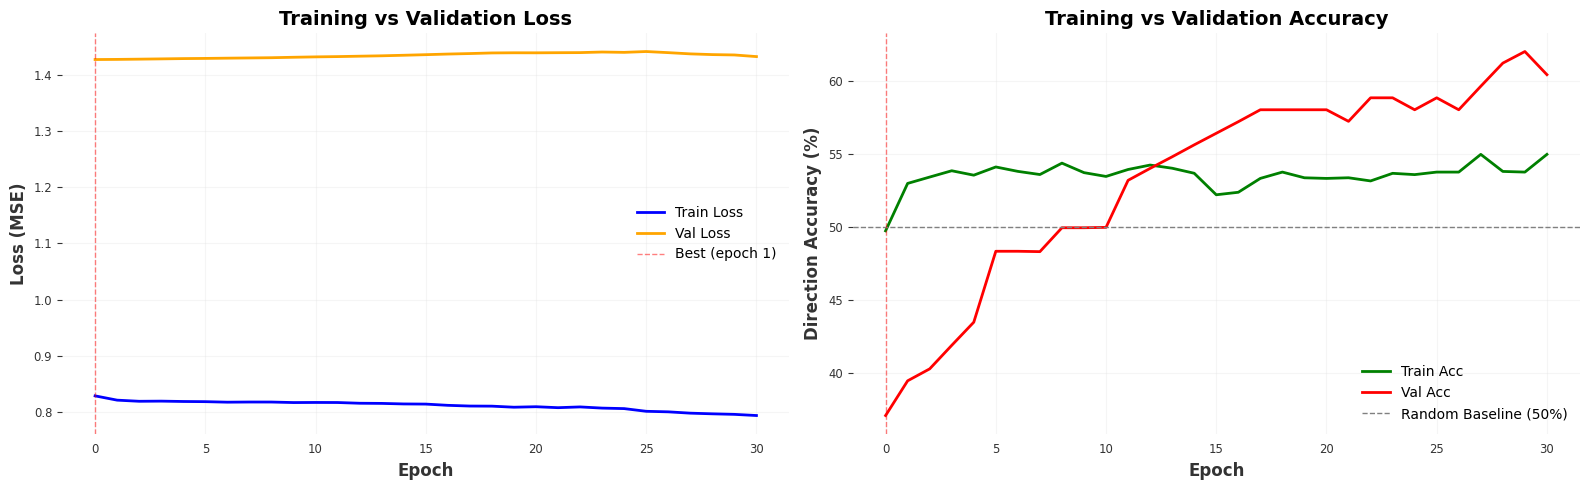

In [290]:
# CELL 8: Plot Training History
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Val Loss', color='orange', linewidth=2)
axes[0].axvline(best_epoch - 1, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Best (epoch {best_epoch})')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accuracy, label='Train Acc', color='green', linewidth=2)
axes[1].plot(val_accuracy, label='Val Acc', color='red', linewidth=2)
axes[1].axhline(50, color='gray', linestyle='--', linewidth=1, label='Random Baseline (50%)')
axes[1].axvline(best_epoch - 1, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Direction Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
LOOKBACK = 60

In [291]:
test_returns = test_tesla['Returns'].dropna().values.reshape(-1, 1)
scaler_ret = StandardScaler()
scaler_ret.fit(train_tesla['Returns'].values.reshape(-1, 1))
test_scaled = scaler_ret.transform(test_returns)

# Get last training sequence
train_returns = train_tesla['Returns'].values.reshape(-1, 1)
train_returns_scaled = scaler_ret.transform(train_returns)
last_train = train_features_scaled[-LOOKBACK:]
all_data = np.vstack([last_train, test_features_scaled])



In [292]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
LOOKBACK = 60

# CELL 10: Make Predictions
predicted_returns_scaled = []
lstm_model.eval()

with torch.no_grad():
    for i in range(len(test_features_scaled)):
        seq = all_data[i:i+LOOKBACK]  # Shape: [LOOKBACK, 3]
        seq_tensor = torch.FloatTensor(seq).unsqueeze(0).to(device)  # Shape: [1, LOOKBACK, 3]
        pred = lstm_model(seq_tensor)
        predicted_returns_scaled.append(pred.cpu().numpy()[0, 0])

# Inverse transform only the first feature (Returns)
predicted_returns_scaled_array = np.array(predicted_returns_scaled).reshape(-1, 1)


predicted_returns = scaler_ret.inverse_transform(predicted_returns_scaled_array).flatten()

# Align sizes
actual_returns = test_tesla['Returns'].values[:len(predicted_returns)]
actual_dates = test_tesla['Date'].values[:len(predicted_returns)]

print(f"Predictions made - Shape: {predicted_returns.shape}")

# CELL 11: Evaluate Model
lstm_rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
lstm_mae = mean_absolute_error(actual_returns, predicted_returns)
direction_correct = (np.sign(actual_returns) == np.sign(predicted_returns)).sum()
lstm_dir_acc = direction_correct / len(actual_returns) * 100

print("\n" + "="*80)
print("📊 LSTM EVALUATION ON TEST DATA")
print("="*80)
print(f"RMSE              : {lstm_rmse:.4f}")
print(f"MAE               : {lstm_mae:.4f}")
print(f"Direction Accuracy: {lstm_dir_acc:.2f}% ({direction_correct}/{len(actual_returns)})")
print(f"Gain vs Random    : {lstm_dir_acc - 50:+.2f}%")
print("="*80)

Predictions made - Shape: (146,)

📊 LSTM EVALUATION ON TEST DATA
RMSE              : 0.0352
MAE               : 0.0272
Direction Accuracy: 46.58% (68/146)
Gain vs Random    : -3.42%


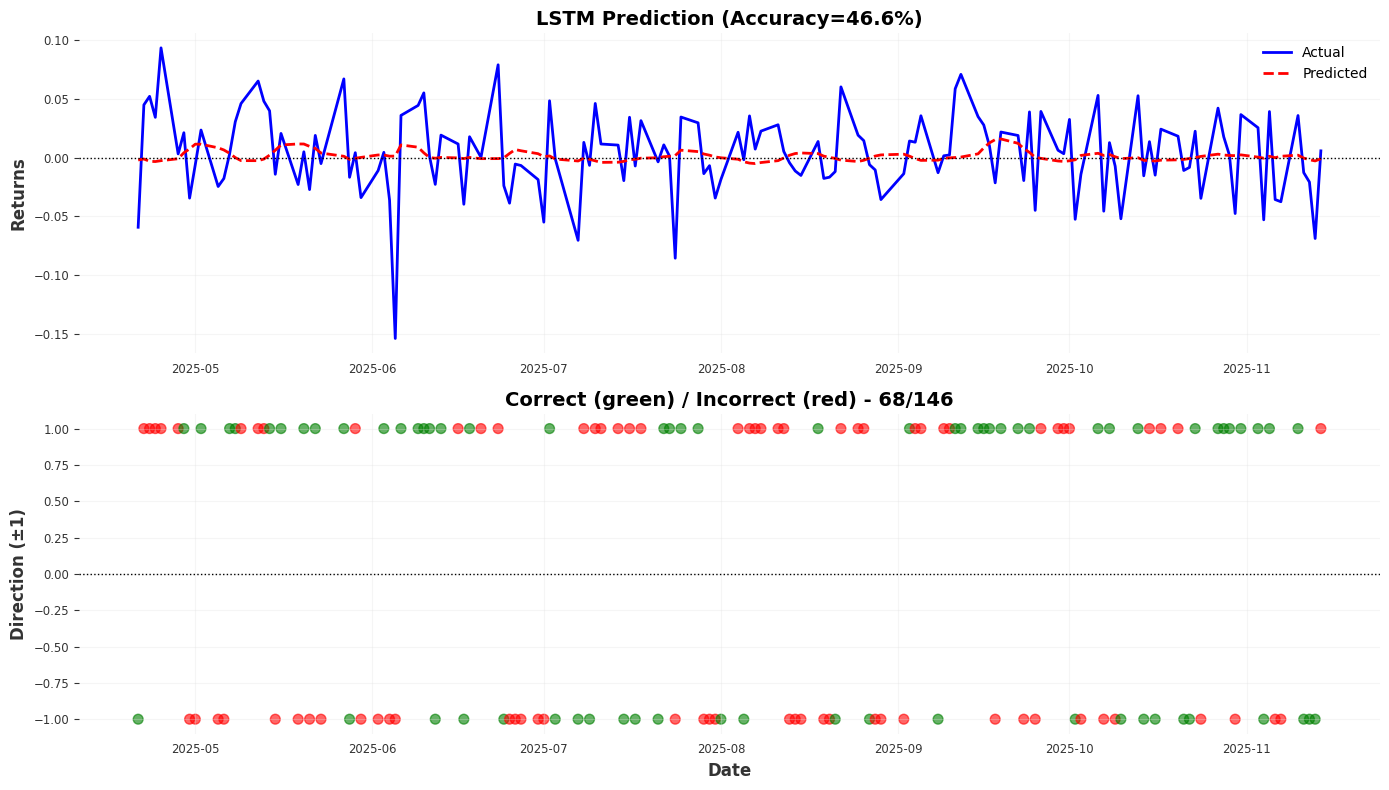

In [293]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Predictions vs Actual
axes[0].plot(actual_dates, actual_returns, label='Actual', color='blue', linewidth=2)
axes[0].plot(actual_dates, predicted_returns, label='Predicted', color='red', linewidth=2, linestyle='--')
axes[0].axhline(0, color='black', linestyle=':', linewidth=1)
axes[0].set_ylabel('Returns', fontsize=12, fontweight='bold')
axes[0].set_title(f'LSTM Prediction (Accuracy={lstm_dir_acc:.1f}%)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Direction Accuracy
correct_mask = (np.sign(actual_returns) == np.sign(predicted_returns))
colors = ['green' if c else 'red' for c in correct_mask]
axes[1].scatter(actual_dates, np.sign(actual_returns), c=colors, alpha=0.6, s=50)
axes[1].axhline(0, color='black', linestyle=':', linewidth=1)
axes[1].set_ylabel('Direction (±1)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=12, fontweight='bold')
axes[1].set_title(f'Correct (green) / Incorrect (red) - {direction_correct}/{len(actual_returns)}', 
                  fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

##### cross validation lstm

In [92]:
from sklearn.model_selection import TimeSeriesSplit

In [294]:

BATCH_SIZE = 64
N_SPLITS = 5
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
results_lstm = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_returns_scaled)):
    print(f"\n===== Fold {fold+1}/{N_SPLITS} =====")
    X_train, X_val = train_returns_scaled[train_idx], train_returns_scaled[val_idx]
    ds_train = TimeSeriesDataset(X_train, lookback=LOOKBACK)
    ds_val = TimeSeriesDataset(X_val, lookback=LOOKBACK)
    train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)

    model = SimpleLSTM(input_size=1, hidden_size=64, num_layers=2, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    best_val_loss = float('inf')
    patience = 15
    patience_counter = 0

    for epoch in range(50):  # moins d'epochs pour cross-val
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = nn.MSELoss()(outputs, y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += nn.MSELoss()(outputs, y_batch).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            break
    model.load_state_dict(best_model)
    results_lstm.append(best_val_loss)
print(f"\nLSTM Cross-Validation MSE (val): {results_lstm}")
print(f"Mean: {np.mean(results_lstm):.4f} | Std: {np.std(results_lstm):.4f}")


===== Fold 1/5 =====

===== Fold 2/5 =====

===== Fold 3/5 =====

===== Fold 4/5 =====

===== Fold 5/5 =====

LSTM Cross-Validation MSE (val): [0.4080917214353879, 0.8696687420209249, 0.8263699014981588, 0.6496008932590485, 1.4780981143315632]
Mean: 0.8464 | Std: 0.3552


### GRU MOdel


In [94]:
HIDDEN_SIZE = 64
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.0005
EPOCHS_GRU = 150

In [295]:
class GRUModel(nn.Module):
    def __init__(self, input_size=3, hidden_size=64, num_layers=2, dropout=0.2):
        super(GRUModel , self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [304]:
gru_model = GRUModel(input_size=3, hidden_size=64, num_layers=2, dropout=0.2).to(device)
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15)
criterian = nn.MSELoss()

In [300]:
train_losses_gru, val_losses_gru = [], []
train_accuracy_gru, val_accuracy_gru = [], []
best_val_loss = float('inf')
best_model_state_gru = None
best_epoch_gru = 0
patience = 30
patience_counter = 0
EPOCHS_GRU = 100

In [301]:
def train_epoch_gru(model, train_loader, optimizer, device):
    model.train()
    train_loss, train_acc, train_batches = 0, 0, 0
    criterion = nn.MSELoss()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        with torch.no_grad():
            if len(y_batch) > 1:
                correct = (torch.sign(y_batch.squeeze()) == torch.sign(outputs.squeeze())).float()
                train_acc += correct.mean().item() * 100
                train_batches += 1
    train_loss /= len(train_loader)
    train_acc = train_acc / train_batches if train_batches > 0 else 0
    return train_loss, train_acc


In [302]:
def validate_epoch_gru(model, val_loader, device):
    model.eval()
    val_loss, val_acc, val_batches = 0, 0, 0
    criterion = nn.MSELoss()
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            if len(y_batch) > 1:
                y_true_changes = torch.diff(y_batch.squeeze())
                y_pred_changes = torch.diff(outputs.squeeze())
                if len(y_true_changes) == len(y_pred_changes):
                    correct = (torch.sign(y_true_changes) == torch.sign(y_pred_changes)).float()
                    val_acc += correct.mean().item() * 100
                    val_batches += 1
    val_loss /= len(val_loader)
    val_acc = val_acc / val_batches if val_batches > 0 else 0
    return val_loss, val_acc


In [311]:
for epoch in range(EPOCHS_GRU):
    train_loss, train_acc = train_epoch_gru(gru_model, train_loader, optimizer, device)
    val_loss, val_acc = validate_epoch_gru(gru_model, val_loader, device)
    train_losses_gru.append(train_loss)
    val_losses_gru.append(val_loss)
    train_accuracy_gru.append(train_acc)
    val_accuracy_gru.append(val_acc)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch_gru = epoch + 1
        best_model_state_gru = gru_model.state_dict().copy()
        patience_counter = 0
        status = "✅"
    else:
        patience_counter += 1
        status = f"⏸ ({patience_counter}/{patience})"
    scheduler.step(val_loss)
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d} {status} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
              f"Train Acc: {train_acc:5.2f}% | Val Acc: {val_acc:5.2f}%")
    if patience_counter >= patience:
        print(f"\n🛑 Early stopping at epoch {epoch+1}")
        break

if best_model_state_gru:
    gru_model.load_state_dict(best_model_state_gru)
    print(f"\n✅ Best GRU model loaded (epoch {best_epoch_gru})")

Epoch   1 ✅ | Train Loss: 0.827282 | Val Loss: 1.425309 | Train Acc: 50.94% | Val Acc: 58.08%
Epoch   5 ⏸️ (4/30) | Train Loss: 0.817958 | Val Loss: 1.428776 | Train Acc: 53.93% | Val Acc: 57.23%
Epoch  10 ⏸️ (9/30) | Train Loss: 0.816429 | Val Loss: 1.432076 | Train Acc: 53.06% | Val Acc: 57.21%
Epoch  15 ⏸️ (14/30) | Train Loss: 0.812180 | Val Loss: 1.438708 | Train Acc: 54.10% | Val Acc: 55.57%
Epoch  20 ⏸️ (19/30) | Train Loss: 0.806555 | Val Loss: 1.443992 | Train Acc: 54.27% | Val Acc: 57.18%
Epoch  25 ⏸️ (24/30) | Train Loss: 0.800321 | Val Loss: 1.447320 | Train Acc: 56.05% | Val Acc: 59.61%
Epoch  30 ⏸️ (29/30) | Train Loss: 0.801317 | Val Loss: 1.449211 | Train Acc: 55.62% | Val Acc: 60.43%

🛑 Early stopping at epoch 31

✅ Best GRU model loaded (epoch 1)


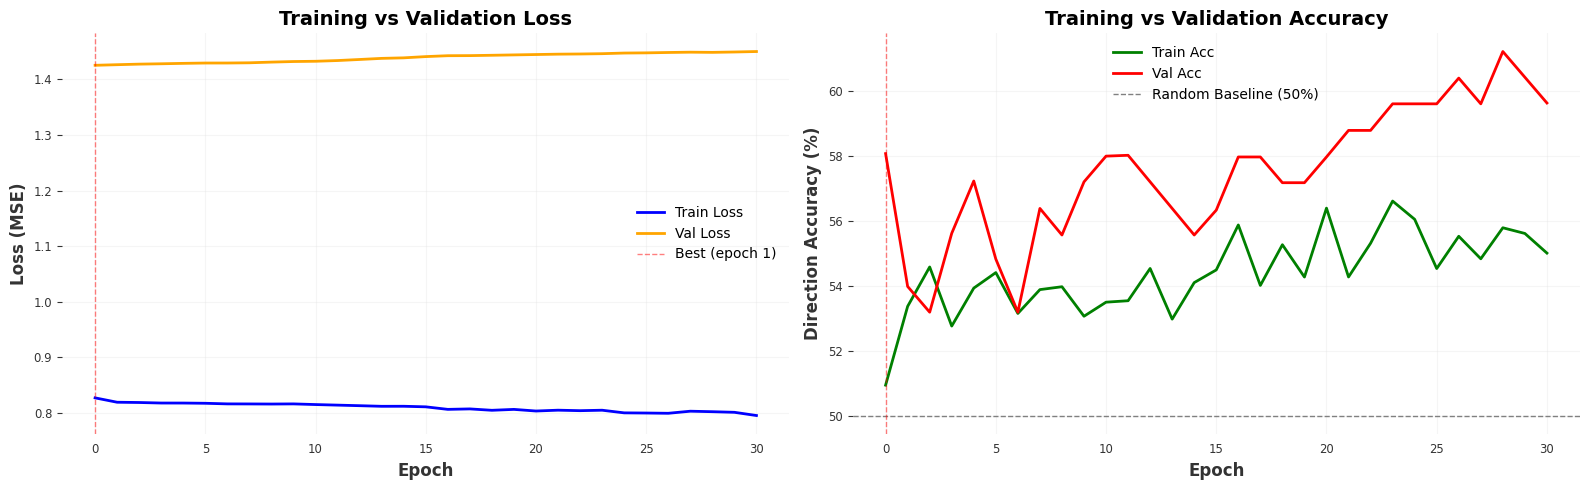

In [316]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss
axes[0].plot(train_losses_gru, label='Train Loss', color='blue', linewidth=2)
axes[0].plot(val_losses_gru, label='Val Loss', color='orange', linewidth=2)
axes[0].axvline(best_epoch_gru - 1, color='red', linestyle='--', linewidth=1, alpha=0.5, label=f'Best (epoch {best_epoch_gru})')
axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accuracy_gru, label='Train Acc', color='green', linewidth=2)
axes[1].plot(val_accuracy_gru, label='Val Acc', color='red', linewidth=2)
axes[1].axhline(50, color='gray', linestyle='--', linewidth=1, label='Random Baseline (50%)')
axes[1].axvline(best_epoch_gru - 1, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Direction Accuracy (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
gru_model.eval()
predicted_returns_scaled = []
with torch.no_grad():
    for i in range(len(test_features_scaled)):
        seq = all_data[i:i+LOOKBACK]
        seq_tensor = torch.FloatTensor(seq).unsqueeze(0).to(device)
        pred = gru_model(seq_tensor)
        predicted_returns_scaled.append(pred.cpu().numpy()[0, 0])
predicted_returns_scaled_array = np.array(predicted_returns_scaled).reshape(-1, 1)
predicted_returns = scaler_ret.inverse_transform(predicted_returns_scaled_array).flatten()
actual_returns = test_tesla['Returns'].values[:len(predicted_returns)]
actual_dates = test_tesla['Date'].values[:len(predicted_returns)]

gru_rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
gru_mae = mean_absolute_error(actual_returns, predicted_returns)
direction_correct = (np.sign(actual_returns) == np.sign(predicted_returns)).sum()
gru_dir_acc = direction_correct / len(actual_returns) * 100

print("="*80)
print("📊 GRU EVALUATION ON TEST DATA")
print("="*80)
print(f"RMSE              : {gru_rmse:.4f}")
print(f"MAE               : {gru_mae:.4f}")
print(f"Direction Accuracy: {gru_dir_acc:.2f}% ({direction_correct}/{len(actual_returns)})")
print(f"Gain vs Random    : {gru_dir_acc - 50:+.2f}%")
print("="*80)


📊 GRU EVALUATION ON TEST DATA
RMSE              : 0.0352
MAE               : 0.0273
Direction Accuracy: 45.89% (67/146)
Gain vs Random    : -4.11%


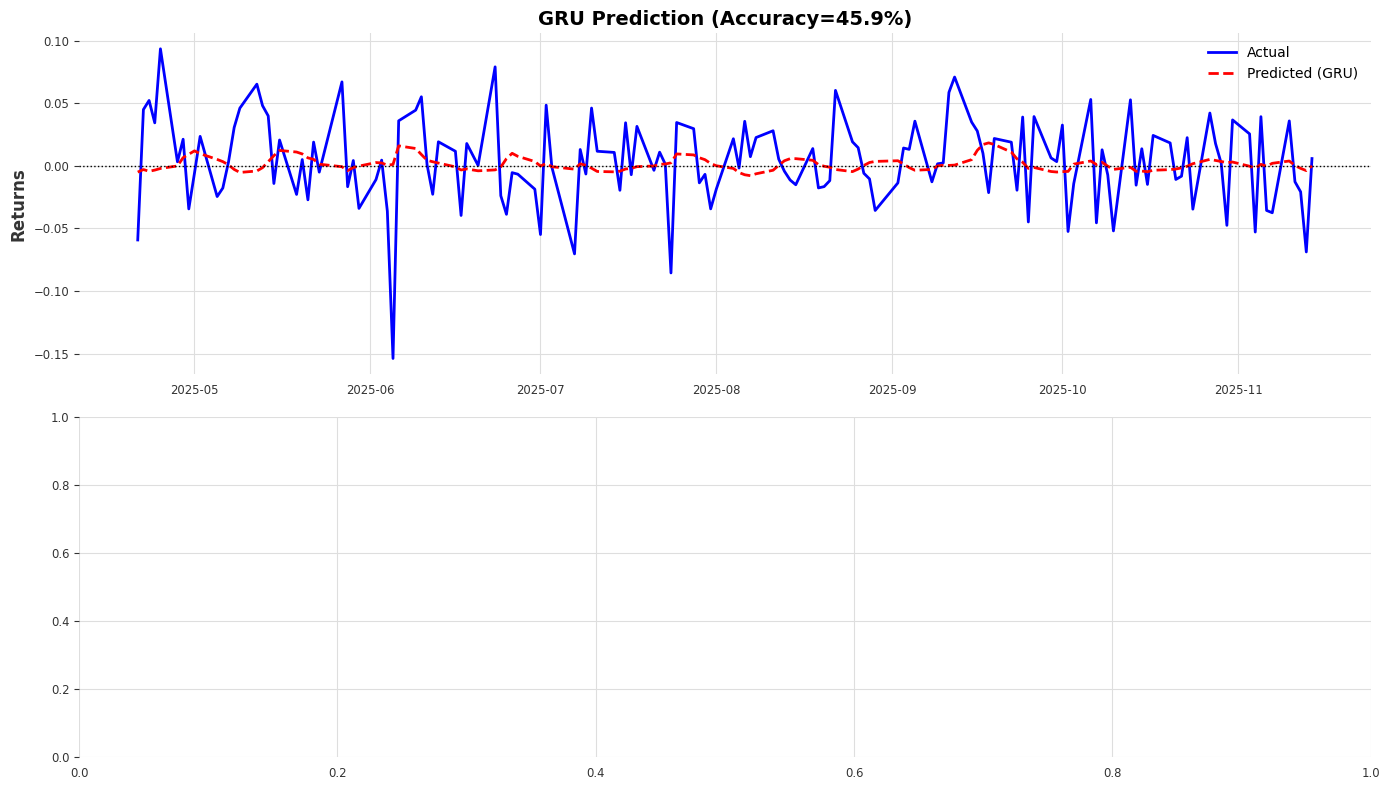

In [319]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(actual_dates, actual_returns, label='Actual', color='blue', linewidth=2)
axes[0].plot(actual_dates, predicted_returns, label='Predicted (GRU)', color='red', linewidth=2, linestyle='--')
axes[0].axhline(0, color='black', linestyle=':', linewidth=1)
axes[0].set_ylabel('Returns', fontsize=12, fontweight='bold')
axes[0].set_title(f'GRU Prediction (Accuracy={gru_dir_acc:.1f}%)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)


plt.tight_layout()
plt.show()

##### Cross validation gru

In [318]:
results_gru = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(train_returns_scaled)):
    print(f"\n===== Fold {fold+1}/{tscv.n_splits} =====")
    X_train, X_val = train_returns_scaled[train_idx], train_returns_scaled[val_idx]
    ds_train = TimeSeriesDataset(X_train, lookback=LOOKBACK)
    ds_val = TimeSeriesDataset(X_val, lookback=LOOKBACK)
    train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)

    model = GRUModel(input_size=1, hidden_size=64, num_layers=2, dropout=0.2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0

    for epoch in range(20):  # epochs réduits
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = nn.MSELoss()(outputs, y_batch)
            loss.backward()
            optimizer.step()
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                val_loss += nn.MSELoss()(outputs, y_batch).item()
        val_loss /= len(val_loader)
        scheduler.step(val_loss)
        print(f"Epoch {epoch+1} | Val Loss: {val_loss:.4f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping.")
            break
    model.load_state_dict(best_model)
    results_gru.append(best_val_loss)
print(f"\nGRU Cross-Validation MSE (val): {results_gru}")
print(f"Mean: {np.mean(results_gru):.4f} | Std: {np.std(results_gru):.4f}")


===== Fold 1/5 =====
Epoch 1 | Val Loss: 0.3968
Epoch 2 | Val Loss: 0.3987
Epoch 3 | Val Loss: 0.4087
Epoch 4 | Val Loss: 0.4230
Epoch 5 | Val Loss: 0.4355
Epoch 6 | Val Loss: 0.4411
Epoch 7 | Val Loss: 0.4400
Epoch 8 | Val Loss: 0.4373
Early stopping.

===== Fold 2/5 =====
Epoch 1 | Val Loss: 0.8555
Epoch 2 | Val Loss: 0.8711
Epoch 3 | Val Loss: 0.8818
Epoch 4 | Val Loss: 0.8802
Epoch 5 | Val Loss: 0.8742
Epoch 6 | Val Loss: 0.8695
Epoch 7 | Val Loss: 0.8675
Epoch 8 | Val Loss: 0.8675
Early stopping.

===== Fold 3/5 =====
Epoch 1 | Val Loss: 0.8386
Epoch 2 | Val Loss: 0.8334
Epoch 3 | Val Loss: 0.8322
Epoch 4 | Val Loss: 0.8313
Epoch 5 | Val Loss: 0.8311
Epoch 6 | Val Loss: 0.8305
Epoch 7 | Val Loss: 0.8298
Epoch 8 | Val Loss: 0.8292
Epoch 9 | Val Loss: 0.8288
Epoch 10 | Val Loss: 0.8286
Epoch 11 | Val Loss: 0.8283
Epoch 12 | Val Loss: 0.8281
Epoch 13 | Val Loss: 0.8281
Epoch 14 | Val Loss: 0.8278
Epoch 15 | Val Loss: 0.8273
Epoch 16 | Val Loss: 0.8270
Epoch 17 | Val Loss: 0.8269
Epo

### ARIMA-LSTM

In [102]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [139]:
features = ['Returns', 'RSI', 'Volume']
train_features = train_tesla[features].dropna().values
test_features = test_tesla[features].dropna().values

# Standardisation (important pour LSTM)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

input_size = train_features_scaled.shape[1]

In [138]:
class MultiFeatureTimeSeriesDataset(Dataset):
    def __init__(self, data, lookback=60):
        self.data = data
        self.lookback = lookback

    def __len__(self):
        return len(self.data) - self.lookback

    def __getitem__(self, idx):
        X = self.data[idx:idx + self.lookback, :]
        y = self.data[idx + self.lookback, 0]  # On prédit Returns
        return torch.FloatTensor(X), torch.FloatTensor([y])

In [141]:
LOOKBACK = 60
BATCH_SIZE = 32

dataset = MultiFeatureTimeSeriesDataset(train_features_scaled, lookback=LOOKBACK)
train_size = int(0.9 * len(dataset))
train_dataset = torch.utils.data.Subset(dataset, range(0, train_size))
val_dataset = torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [193]:
class ARIMA_LSTM:
    def __init__(self, arima_order, lstm_hidden=64, lstm_layers=2, 
                 input_size=3, lookback=60, device='cpu'):
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers
        self.lookback = lookback
        self.device = device
        self.input_size = input_size
        self.arima_order = arima_order
        self.lstm_model = None
        self.scaler = StandardScaler()
        self.arima_fitted = None
        self.history = {
            'train_losses': [],
            'val_losses': [],
            'train_accuracy': [],
            'val_accuracy': []
        }
    
    def fit_arima(self, train_data):
        """Fit ARIMA model and return residuals"""
        if isinstance(train_data, pd.Series):
            self.train_data = train_data.values.copy()
        else:
            self.train_data = train_data.copy()
        
        model = ARIMA(self.train_data, order=self.arima_order)
        self.arima_fitted = model.fit()
        
        print("\n" + "="*80)
        print("📊 ARIMA MODEL SUMMARY")
        print("="*80)
        print(f"Order             : ARIMA{self.arima_order}")
        print(f"AIC               : {self.arima_fitted.aic:.2f}")
        print(f"BIC               : {self.arima_fitted.bic:.2f}")
        print(f"HQIC              : {self.arima_fitted.hqic:.2f}")
        print(f"Log-Likelihood    : {self.arima_fitted.llf:.2f}")
        
        print("\n📈 Coefficients & P-values:")
        params = self.arima_fitted.params
        pvalues = self.arima_fitted.pvalues
        
        for i, (param, pval) in enumerate(zip(params, pvalues)):
            sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
            print(f"  Param {i}: {param:8.4f} (p={pval:.4f}) {sig}")
        print("="*80)
        
        residuals = self.train_data - self.arima_fitted.fittedvalues
        return residuals

In [208]:
arima_lstm_model = ARIMA_LSTM(
    arima_order=(1, 1, 1),
    lstm_hidden=64,
    lstm_layers=2,
    input_size=3,
    lookback=60,
    device=device
)

In [196]:

residuals = arima_lstm_model.fit_arima(train_tesla['Returns'])


📊 ARIMA MODEL SUMMARY
Order             : ARIMA(1, 1, 1)
AIC               : -4544.04
BIC               : -4528.49
HQIC              : -4538.21
Log-Likelihood    : 2275.02

📈 Coefficients & P-values:
  Param 0:  -0.0176 (p=0.4646) 
  Param 1:  -0.9969 (p=0.0000) ***
  Param 2:   0.0018 (p=0.0000) ***


In [ ]:
def train_arima_lstm(model, train_loader_input, val_loader_input, epochs=100, lr=0.0005):
    model.lstm_model = SimpleLSTM(
        input_size=model.input_size,
        hidden_size=model.lstm_hidden,
        num_layers=model.lstm_layers,
        dropout=0.2
    ).to(model.device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.lstm_model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=10
    )

    best_val_loss = float('inf')
    best_state = None
    best_epoch = 0
    patience = 20
    patience_counter = 0

    for epoch in range(epochs):
        model.lstm_model.train()
        train_loss = 0
        train_acc = 0
        train_batches = 0

        for X, y in train_loader_input:
            X, y = X.to(model.device), y.to(model.device)
            optimizer.zero_grad()
            out = model.lstm_model(X)
            loss = criterion(out, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.lstm_model.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

            # Robust direction accuracy
            with torch.no_grad():
                y_true = y.squeeze()
                y_pred = out.squeeze()
                y_true = y_true.flatten()
                y_pred = y_pred.flatten()
                min_len = min(len(y_true), len(y_pred))
                if min_len > 1:
                    y_true_changes = torch.diff(y_true[:min_len])
                    y_pred_changes = torch.diff(y_pred[:min_len])
                    min_diff = min(len(y_true_changes), len(y_pred_changes))
                    if min_diff > 0:
                        correct = (torch.sign(y_true_changes[:min_diff]) == torch.sign(y_pred_changes[:min_diff])).float()
                        train_acc += correct.mean().item() * 100
                        train_batches += 1

        train_loss /= len(train_loader_input)
        train_acc = train_acc / train_batches if train_batches > 0 else 0

        model.lstm_model.eval()
        val_loss = 0
        val_acc = 0
        val_batches = 0

        with torch.no_grad():
            for X, y in val_loader_input:
                X, y = X.to(model.device), y.to(model.device)
                out = model.lstm_model(X)
                val_loss += criterion(out, y).item()

                y_true = y.squeeze()
                y_pred = out.squeeze()
                y_true = y_true.flatten()
                y_pred = y_pred.flatten()
                min_len = min(len(y_true), len(y_pred))
                if min_len > 1:
                    y_true_changes = torch.diff(y_true[:min_len])
                    y_pred_changes = torch.diff(y_pred[:min_len])
                    min_diff = min(len(y_true_changes), len(y_pred_changes))
                    if min_diff > 0:
                        correct = (torch.sign(y_true_changes[:min_diff]) == torch.sign(y_pred_changes[:min_diff])).float()
                        val_acc += correct.mean().item() * 100
                        val_batches += 1

        val_loss /= len(val_loader_input)
        val_acc = val_acc / val_batches if val_batches > 0 else 0

        model.history['train_losses'].append(train_loss)
        model.history['val_losses'].append(val_loss)
        model.history['train_accuracy'].append(train_acc)
        model.history['val_accuracy'].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = model.lstm_model.state_dict().copy()
            best_epoch = epoch + 1
            patience_counter = 0
        else:
            patience_counter += 1

        scheduler.step(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1:3d}/{epochs} | "
                  f"Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | "
                  f"Train Acc: {train_acc:5.2f}% | Val Acc: {val_acc:5.2f}%")

        if patience_counter >= patience:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

    if best_state:
        model.lstm_model.load_state_dict(best_state)

    print("\n" + "="*80)
    print("📊 LSTM TRAINING SUMMARY")
    print("="*80)
    print(f"Best val accuracy : {model.history['val_accuracy'][best_epoch-1]:.2f}%")
    print(f"Final train loss  : {model.history['train_losses'][-1]:.6f}")
    print(f"Final train acc   : {model.history['train_accuracy'][-1]:.2f}%")
    print(f"Gain vs Random    : {model.history['val_accuracy'][best_epoch-1] - 50:+.2f}%")
    print("="*80)

In [214]:
train_arima_lstm(arima_lstm_model, train_loader, val_loader, epochs=100, lr=0.0005)

Epoch  10/100 | Train Loss: 0.722956 | Val Loss: 0.929113 | Train Acc: 51.72% | Val Acc: 53.24%
Epoch  20/100 | Train Loss: 0.708044 | Val Loss: 0.923490 | Train Acc: 50.88% | Val Acc: 59.64%
Epoch  30/100 | Train Loss: 0.706934 | Val Loss: 0.921786 | Train Acc: 48.68% | Val Acc: 58.03%
Epoch  40/100 | Train Loss: 0.705930 | Val Loss: 0.920608 | Train Acc: 52.07% | Val Acc: 57.23%
Epoch  50/100 | Train Loss: 0.704129 | Val Loss: 0.920720 | Train Acc: 52.47% | Val Acc: 56.41%
Epoch  60/100 | Train Loss: 0.702494 | Val Loss: 0.920883 | Train Acc: 48.68% | Val Acc: 56.44%

🛑 Early stopping at epoch 65

📊 LSTM TRAINING SUMMARY
Best epoch        : 45
Best val loss     : 0.920404
Best val accuracy : 56.41%
Final train loss  : 0.701972
Final train acc   : 51.06%
Gain vs Random    : +6.41%


In [ ]:
def evaluate(model, test_loader):
    
    model.lstm_model.eval()
    test_loss = 0
    test_acc = 0
    test_batches = 0

    criterion = nn.MSELoss()

    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(model.device), y.to(model.device)
            out = model.lstm_model(X)
            loss = criterion(out, y)
            test_loss += loss.item()

            # Robust direction accuracy
            y_true = y.squeeze().flatten()
            y_pred = out.squeeze().flatten()
            min_len = min(len(y_true), len(y_pred))
            if min_len > 1:
                y_true_changes = torch.diff(y_true[:min_len])
                y_pred_changes = torch.diff(y_pred[:min_len])
                min_diff = min(len(y_true_changes), len(y_pred_changes))
                if min_diff > 0:
                    correct = (torch.sign(y_true_changes[:min_diff]) == torch.sign(y_pred_changes[:min_diff])).float()
                    test_acc += correct.mean().item() * 100
                    test_batches += 1

    test_loss /= len(test_loader)
    test_acc = test_acc / test_batches if test_batches > 0 else 0
   
    print("\n" + "="*80)
    print("📊 MODEL EVALUATION")
    print("="*80)
    print(f"Test Loss         : {test_loss:.6f}")
    print(f"Test Accuracy     : {test_acc:.2f}%")
    print(f"Gain vs Random    : {test_acc - 50:+.2f}%")
    print("="*80)

    return {'loss': test_loss, 'accuracy': test_acc}

metrics = evaluate(arima_lstm_model, val_loader)


📊 MODEL EVALUATION
Test Loss         : 0.920997
Test Accuracy     : 56.44%
Gain vs Random    : +6.44%


ARIMA-LSTM Test RMSE: 0.12429491171071769
ARIMA-LSTM Test MAE: 0.10737476071597622
ARIMA-LSTM Test Direction Accuracy: 44.18604651162791


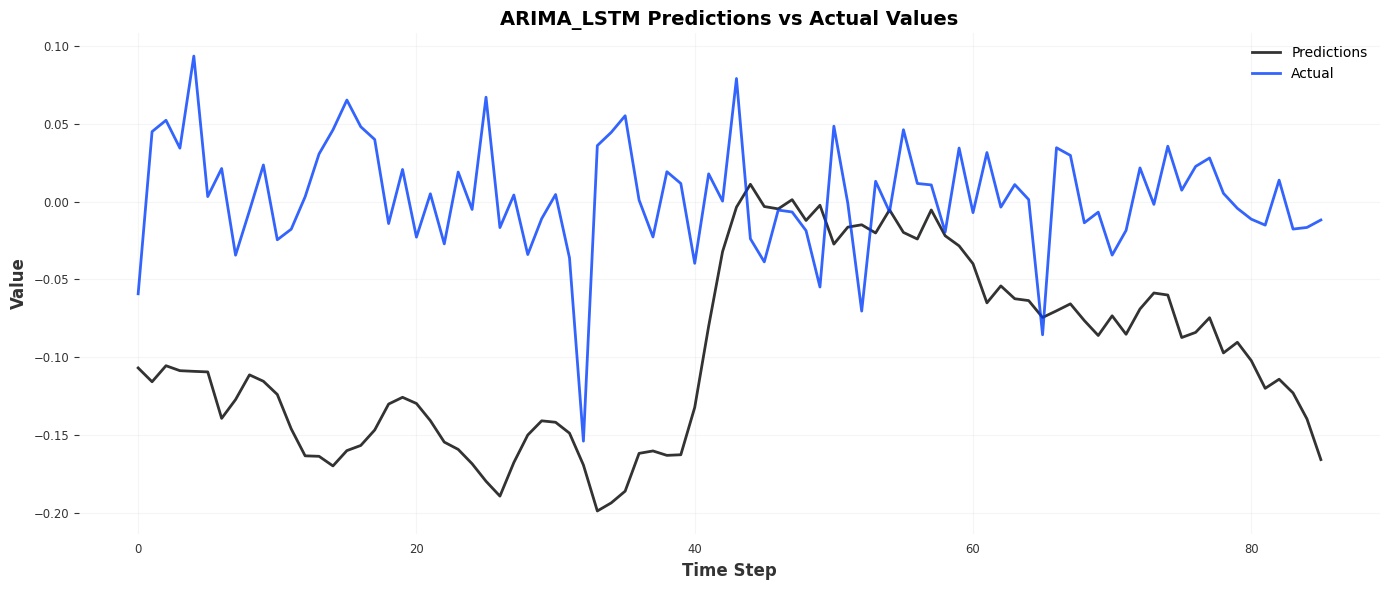

In [328]:

arima_lstm_model.lstm_model.eval()
predictions = []
    
with torch.no_grad():
        for i in range(len(test_features) - arima_lstm_model.lookback):
            seq = test_features_scaled[i:i+arima_lstm_model.lookback, :]  
            seq_tensor = torch.FloatTensor(seq).unsqueeze(0).to(arima_lstm_model.device)
            pred = arima_lstm_model.lstm_model(seq_tensor)
            predictions.append(pred.cpu().numpy()[0, 0])
    
predictions = np.array(predictions)
n = min(len(test_tesla['Returns'].values), len(predictions))
arima_lstm_actual = test_tesla['Returns'].values[:n]
arima_lstm_pred = predictions[:n]

# Compute metrics
arima_lstm_rmse = np.sqrt(mean_squared_error(arima_lstm_actual, arima_lstm_pred))
arima_lstm_mae = mean_absolute_error(arima_lstm_actual, arima_lstm_pred)
arima_lstm_dir_acc = (np.sign(arima_lstm_actual) == np.sign(arima_lstm_pred)).mean() * 100

print("ARIMA-LSTM Test RMSE:", arima_lstm_rmse)
print("ARIMA-LSTM Test MAE:", arima_lstm_mae)
print("ARIMA-LSTM Test Direction Accuracy:", arima_lstm_dir_acc)
    
plt.figure(figsize=(14, 6))
plt.plot(predictions, label='Predictions', linewidth=2, alpha=0.8)

if arima_lstm_actual is not None:
        plt.plot(arima_lstm_actual[:len(predictions)], label='Actual', linewidth=2, alpha=0.8)
    
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.title('ARIMA_LSTM Predictions vs Actual Values', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



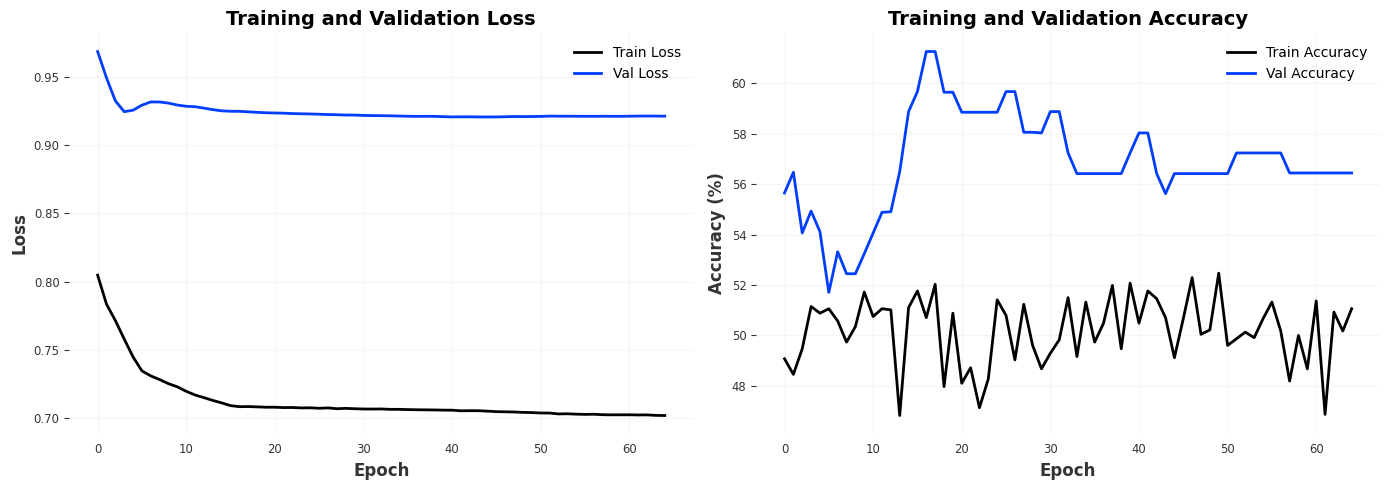

In [230]:
def plot_training_history(model):
    """Plot training and validation loss and accuracy"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot Loss
    axes[0].plot(model.history['train_losses'], label='Train Loss', linewidth=2)
    axes[0].plot(model.history['val_losses'], label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Plot Accuracy
    axes[1].plot(model.history['train_accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(model.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(arima_lstm_model)

##### cross validation lstm_arima

In [320]:
def cross_validate(train_features_scaled, n_splits=5):
    """Perform time series cross-validation"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    cv_results = []
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_features_scaled)):
        train_features_cv = train_features_scaled[train_idx]
        val_features_cv = train_features_scaled[val_idx]
        
        dataset_cv = TimeSeriesDataset(train_features_cv, lookback=60)
        train_size_cv = int(0.9 * len(dataset_cv))
        
        train_dataset_cv = torch.utils.data.Subset(dataset_cv, range(0, train_size_cv))
        val_dataset_cv = torch.utils.data.Subset(dataset_cv, range(train_size_cv, len(dataset_cv)))
        
        train_loader_cv = DataLoader(train_dataset_cv, batch_size=64, shuffle=False)
        val_loader_cv = DataLoader(val_dataset_cv, batch_size=64, shuffle=False)
        
        model_cv = ARIMA_LSTM(
            arima_order=(1, 1, 1),
            lstm_hidden=64,
            lstm_layers=2,
            input_size=3,
            lookback=60,
            device=device
        )
        
        train_arima_lstm(model_cv, train_loader_cv, val_loader_cv, epochs=30, lr=0.0005)
        
        val_loss = model_cv.history['val_losses'][-1]
        cv_results.append(val_loss)
        print(f"Fold {fold + 1}/{n_splits} - Val Loss: {val_loss:.4f}")
    
    print("\n" + "="*80)
    print("📊 CROSS-VALIDATION RESULTS")
    print("="*80)
    print(f"ARIMA-LSTM Cross-Validation MSE: {[f'{x:.4f}' for x in cv_results]}")
    print(f"Mean CV MSE       : {np.mean(cv_results):.4f}")
    print(f"Std CV MSE        : {np.std(cv_results):.4f}")
    print("="*80)
    
    return cv_results

arima_lstm_results = cross_validate(train_features_scaled, n_splits=5)

Epoch  10/30 | Train Loss: 1.122941 | Val Loss: 1.028102 | Train Acc: 56.28% | Val Acc: 62.50%
Epoch  20/30 | Train Loss: 1.122295 | Val Loss: 1.039208 | Train Acc: 58.86% | Val Acc: 62.50%

🛑 Early stopping at epoch 22

📊 LSTM TRAINING SUMMARY
Best epoch        : 2
Best val loss     : 1.011209
Best val accuracy : 12.50%
Final train loss  : 1.120252
Final train acc   : 57.41%
Gain vs Random    : -37.50%
Fold 1/5 - Val Loss: 1.0402
Epoch  10/30 | Train Loss: 0.893389 | Val Loss: 0.116503 | Train Acc: 57.94% | Val Acc: 52.63%
Epoch  20/30 | Train Loss: 0.890413 | Val Loss: 0.117641 | Train Acc: 60.32% | Val Acc: 52.63%

🛑 Early stopping at epoch 24

📊 LSTM TRAINING SUMMARY
Best epoch        : 4
Best val loss     : 0.115156
Best val accuracy : 42.11%
Final train loss  : 0.889657
Final train acc   : 62.70%
Gain vs Random    : -7.89%
Fold 2/5 - Val Loss: 0.1181
Epoch  10/30 | Train Loss: 0.981402 | Val Loss: 0.667031 | Train Acc: 55.03% | Val Acc: 59.32%
Epoch  20/30 | Train Loss: 0.975545 

### Prophet RNN Model

In [183]:
def prepare_prophet_data(df, date_col='Date', target_col='Returns', 
                         regressor_cols=['RSI', 'Volume']):
    """Prepare data in Prophet format"""
    regressor_names = ['rsi', 'volume']
    
    df_prophet = df[[date_col, target_col]].rename(
        columns={date_col: 'ds', target_col: 'y'}
    ).copy()
    
    for orig_name, prop_name in zip(regressor_cols, regressor_names):
        df_prophet[prop_name] = df[orig_name].values
    
    return df_prophet

train_prophet = prepare_prophet_data(train_tesla)
test_prophet = prepare_prophet_data(test_tesla)

In [184]:
print(f"Train data shape: {train_prophet.shape}")
print(f"Test data shape: {test_prophet.shape}")
print(train_prophet.head())

Train data shape: (1317, 4)
Test data shape: (146, 4)
          ds         y        rsi       volume
0 2020-01-23  0.004624  81.575907  294765000.0
1 2020-01-24 -0.012981  78.789833  215304000.0
2 2020-01-27 -0.012112  76.207187  204121500.0
3 2020-01-28  0.015788  77.255654  176827500.0
4 2020-01-29  0.024551  78.848365  267022500.0


In [185]:
split_idx = int(0.9 * len(train_prophet))
train_df = train_prophet.iloc[:split_idx].reset_index(drop=True)
val_df = train_prophet.iloc[split_idx:].reset_index(drop=True)

print(f"Train split: {len(train_df)}")
print(f"Val split: {len(val_df)}")

Train split: 1185
Val split: 132


In [186]:
NP_EPOCHS = 50
prophet_rnn = NeuralProphet(
    n_forecasts=1,
    n_lags=20,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    learning_rate=0.0005,
    epochs=NP_EPOCHS,
    batch_size=32,
    loss_func="MSE",
    normalize="standardize",
    trend_reg=3,
    ar_layers=[32],
    trend_global_local="global",
)

prophet_rnn.add_future_regressor("rsi")
prophet_rnn.add_future_regressor("volume")

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


In [113]:
prophet_rnn.add_future_regressor("rsi")
prophet_rnn.add_future_regressor("volume")


In [187]:
metrics_df = prophet_rnn.fit(train_df, freq="D", validation_df=val_df, progress="bar")

history_np = {
    "loss": metrics_df["Loss"].tolist(),
    "val_loss": metrics_df["ValLoss"].tolist() if "ValLoss" in metrics_df else [np.nan] * len(metrics_df),
}

print("\n" + "="*80)
print("📊 PROPHET-RNN TRAINING SUMMARY")
print("="*80)
print(f"Epochs trained    : {len(metrics_df)}")
print(f"Final train loss  : {history_np['loss'][-1]:.6f}")
if not np.isnan(history_np['val_loss'][-1]):
    print(f"Final val loss    : {history_np['val_loss'][-1]:.6f}")
print("="*80)


WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.287% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 535 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 535 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 535 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 535 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 535 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 535 missing values in column volume were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 535 NaN values in column volume we

Epoch 50: 100%|██████████| 50/50 [00:00<00:00, 173.32it/s, loss=0.737, v_num=6, MAE_val=0.0351, RMSE_val=0.0472, Loss_val=1.440, RegLoss_val=0.000, MAE=0.0296, RMSE=0.0394, Loss=0.721, RegLoss=0.000]  

📊 PROPHET-RNN TRAINING SUMMARY
Epochs trained    : 50
Final train loss  : 0.721407


In [188]:
full_prophet = pd.concat([train_prophet, test_prophet]).reset_index(drop=True)

future = prophet_rnn.make_future_dataframe(
    df=full_prophet,
    periods=0,
    n_historic_predictions=len(train_prophet),
    regressors_df=full_prophet[["ds", "rsi", "volume"]],
)

forecast = prophet_rnn.predict(future)

pred_start = len(train_prophet)
predictions_np = forecast["yhat1"].iloc[pred_start:pred_start + len(test_prophet)].to_numpy()
actual_np = test_prophet["y"].to_numpy()

print(f"Predictions shape: {predictions_np.shape}")
print(f"Actual shape: {actual_np.shape}")


INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.241% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.185% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.188% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 604 missing dates.
INFO - (NP.data.processing._handle_missing_data) - Dropped 1 rows at the end with NaNs in future regressors.
WARNING - (NP.data.processing._handle_missing_data) - 604 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 604 NaN values in c

Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 128.56it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column



Predictions shape: (146,)
Actual shape: (146,)


In [189]:
rmse_np = np.sqrt(mean_squared_error(actual_np, predictions_np))
mae_np = mean_absolute_error(actual_np, predictions_np)
direction_mask = np.sign(actual_np) == np.sign(predictions_np)
direction_acc_np = direction_mask.mean() * 100

print("\n" + "="*80)
print("📊 PROPHET-RNN EVALUATION")
print("="*80)
print(f"RMSE              : {rmse_np:.4f}")
print(f"MAE               : {mae_np:.4f}")
print(f"Direction Accuracy: {direction_acc_np:.2f}% ({direction_mask.sum()}/{len(direction_mask)})")
print(f"Gain vs Random    : {direction_acc_np - 50:+.2f}%")
print("="*80)



📊 PROPHET-RNN EVALUATION
RMSE              : 0.0372
MAE               : 0.0284
Direction Accuracy: 53.42% (78/146)
Gain vs Random    : +3.42%


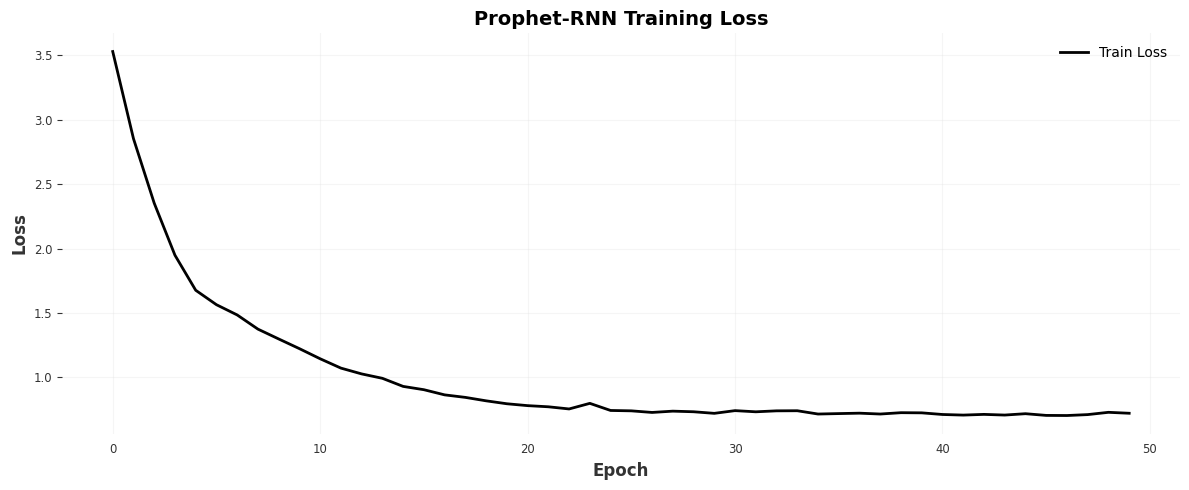

In [190]:
plt.figure(figsize=(12, 5))
plt.plot(history_np['loss'], label='Train Loss', linewidth=2)
if not all(np.isnan(history_np['val_loss'])):
    plt.plot(history_np['val_loss'], label='Val Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Prophet-RNN Training Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

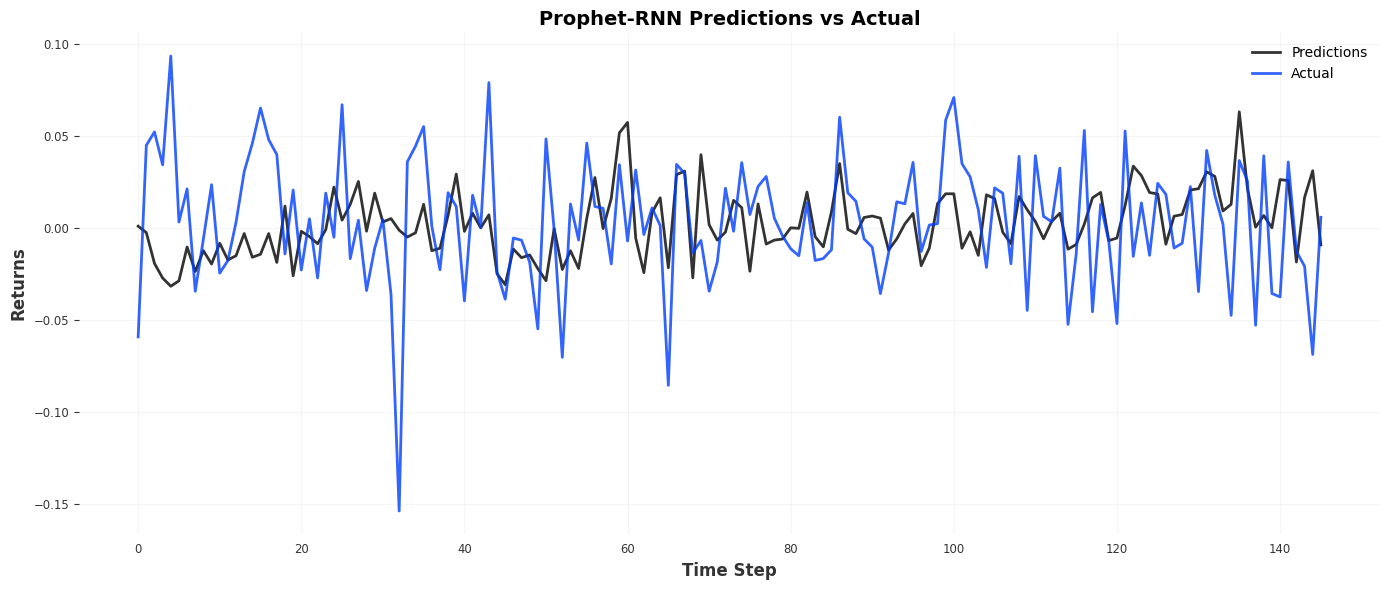

In [191]:
plt.figure(figsize=(14, 6))
plt.plot(predictions_np, label='Predictions', linewidth=2, alpha=0.8)
plt.plot(actual_np, label='Actual', linewidth=2, alpha=0.8)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Returns', fontsize=12)
plt.title('Prophet-RNN Predictions vs Actual', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

###### cross validation 

In [192]:
tscv = TimeSeriesSplit(n_splits=5)
results_prophet = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_prophet)):
    train_df_cv = train_prophet.iloc[train_idx].reset_index(drop=True)
    val_df_cv = train_prophet.iloc[val_idx].reset_index(drop=True)
    
    model_cv = NeuralProphet(
        n_forecasts=1, 
        n_lags=20, 
        epochs=30, 
        batch_size=32, 
        learning_rate=0.0005,
        trend_reg=3, 
        ar_layers=[32], 
        trend_global_local="global"
    )
    
    model_cv.add_future_regressor("rsi")
    model_cv.add_future_regressor("volume")
    
    metrics_df_cv = model_cv.fit(train_df_cv, freq="D", validation_df=val_df_cv, progress="none")
    
    if "ValLoss" in metrics_df_cv.columns:
        val_loss = metrics_df_cv["ValLoss"].dropna().values[-1]
    else:
        val_loss = metrics_df_cv["Loss"].dropna().values[-1]
    
    results_prophet.append(val_loss)
    print(f"Fold {fold + 1}/5 - Val Loss: {val_loss:.4f}")

print("\n" + "="*80)
print("📊 CROSS-VALIDATION RESULTS")
print("="*80)
print(f"Prophet-RNN Cross-Validation MSE: {results_prophet}")
print(f"Mean CV MSE       : {np.mean(results_prophet):.4f}")
print(f"Std CV MSE        : {np.std(results_prophet):.4f}")
print("="*80)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.847% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 98 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 98 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 98 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 98 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 98 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 98 missing values in column volume were detected in total. 


Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 327.26it/s, loss=0.239, v_num=7, MAE_val=0.145, RMSE_val=0.198, Loss_val=0.310, RegLoss_val=0.000, MAE=0.149, RMSE=0.191, Loss=0.238, RegLoss=0.000]  
Fold 1/5 - Val Loss: 0.2381


INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.599% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 196 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 196 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 196 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 196 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 196 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 196 missing values in column volume were detected in to

Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 230.28it/s, loss=0.0597, v_num=8, MAE_val=0.0509, RMSE_val=0.0631, Loss_val=0.0646, RegLoss_val=0.000, MAE=0.0578, RMSE=0.0822, Loss=0.0597, RegLoss=0.000]  

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.515% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 294 missing dates.



Fold 2/5 - Val Loss: 0.0597


WARNING - (NP.data.processing._handle_missing_data) - 294 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 294 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 294 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 294 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 294 missing values in column volume were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 294 NaN values in column volume were auto-imputed.
INFO - (NP.data.processing._handle_missing_data) - Added 99 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 99 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 99 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 99 missing values in column rsi

Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 155.55it/s, loss=0.0876, v_num=9, MAE_val=0.0583, RMSE_val=0.0745, Loss_val=0.0873, RegLoss_val=0.000, MAE=0.0735, RMSE=0.0964, Loss=0.0912, RegLoss=0.000]  

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.246% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 396 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 396 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 396 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 396 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 396 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 396 missing values in column volume were detected in to


Fold 3/5 - Val Loss: 0.0912
Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 116.91it/s, loss=0.171, v_num=10, MAE_val=0.0993, RMSE_val=0.122, Loss_val=0.200, RegLoss_val=0.000, MAE=0.114, RMSE=0.159, Loss=0.169, RegLoss=0.000]  

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.266% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.data.processing._handle_missing_data) - Added 496 missing dates.
WARNING - (NP.data.processing._handle_missing_data) - 496 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 496 NaN values in column y were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 496 missing values in column rsi were detected in total. 
INFO - (NP.data.processing._handle_missing_data) - 496 NaN values in column rsi were auto-imputed.
WARNING - (NP.data.processing._handle_missing_data) - 496 missing values in column volume were detected in to


Fold 4/5 - Val Loss: 0.1691
Epoch 30: 100%|██████████| 30/30 [00:00<00:00, 106.06it/s, loss=0.0634, v_num=11, MAE_val=0.0562, RMSE_val=0.078, Loss_val=0.0886, RegLoss_val=0.000, MAE=0.0559, RMSE=0.0755, Loss=0.0585, RegLoss=0.000]   
Fold 5/5 - Val Loss: 0.0585

📊 CROSS-VALIDATION RESULTS
Prophet-RNN Cross-Validation MSE: [0.2381415069103241, 0.059730254113674164, 0.09122167527675629, 0.1691194474697113, 0.05854148417711258]
Mean CV MSE       : 0.1234
Std CV MSE        : 0.0701


## Comparaison des models

In [321]:
# Résumés des résultats de cross-validation
cv_results = {
    "LSTM": results_lstm,
    "GRU": results_gru,
    "ARIMA-LSTM": arima_lstm_results,
    "Prophet-RNN": results_prophet
}

summary = []
for name, scores in cv_results.items():
    summary.append({
        "Modèle": name,
        "Moyenne MSE": np.mean(scores),
        "Écart-type": np.std(scores),
        "Meilleur (min)": np.min(scores),
        "Moins bon (max)": np.max(scores)
    })

df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values("Moyenne MSE")
print(df_summary)


        Modèle  Moyenne MSE  Écart-type  Meilleur (min)  Moins bon (max)
3  Prophet-RNN     0.123351    0.070074        0.058541         0.238142
2   ARIMA-LSTM     0.624762    0.295389        0.118063         1.040237
1          GRU     0.841411    0.358252        0.396757         1.479020
0         LSTM     0.846366    0.355198        0.408092         1.478098


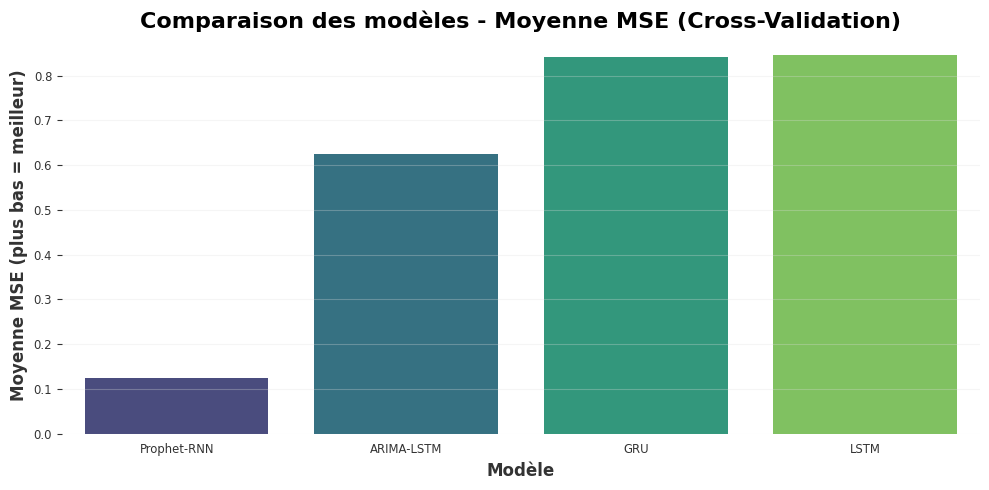

In [322]:
import matplotlib.pyplot as plt
import seaborn as sns

# df_summary doit déjà exister (voir ta cellule "Comparaison des models")
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_summary,
    x="Modèle",
    y="Moyenne MSE",
    palette="viridis"
)
plt.title("Comparaison des modèles - Moyenne MSE (Cross-Validation)", fontsize=16, fontweight='bold')
plt.ylabel("Moyenne MSE (plus bas = meilleur)", fontsize=12)
plt.xlabel("Modèle", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


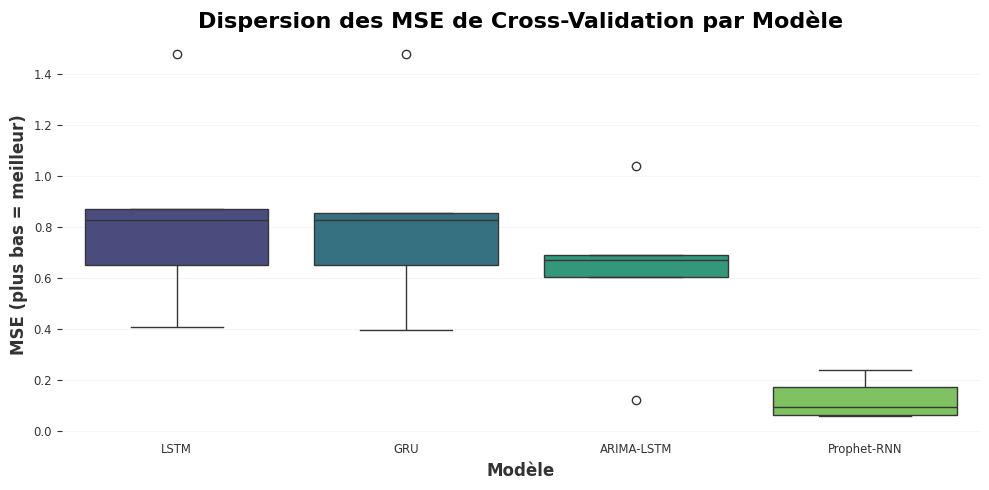

In [324]:
# Boxplot pour la dispersion des scores de CV
cv_df = pd.DataFrame({
    "LSTM": results_lstm,
    "GRU": results_gru,
    "ARIMA-LSTM": arima_lstm_results,
    "Prophet-RNN": results_prophet
})
plt.figure(figsize=(10, 5))
sns.boxplot(data=cv_df, palette="viridis")
plt.title("Dispersion des MSE de Cross-Validation par Modèle", fontsize=16, fontweight='bold')
plt.ylabel("MSE (plus bas = meilleur)", fontsize=12)
plt.xlabel("Modèle", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

##### exportation des resultats

In [120]:
import pandas as pd

# Statistiques descriptives principales
desc = tsla_data.describe(include='all')
desc.to_csv('data_export/desc_tsla.csv')

# Statistiques sur les rendements uniquement
desc_returns = tsla_data['Returns'].describe()
desc_returns.to_csv('data_export/desc_returns.csv')

In [ ]:

lstm_pred_df = pd.DataFrame({
    'Date': actual_dates,
    'Actual_Returns': actual_returns,
    'LSTM_Pred': predicted_returns
})
lstm_pred_df.to_csv('data_export/lstm_predictions.csv', index=False)

# Exemple pour GRU (même structure)
gru_pred_df = pd.DataFrame({
    'Date': actual_dates,
    'Actual_Returns': actual_returns,
    'GRU_Pred': predicted_returns
})
gru_pred_df.to_csv('data_export/gru_predictions.csv', index=False)

# Pour ARIMA-LSTM

n = min(len(test_tesla['Date'].values), len(test_tesla['Returns'].values), len(predictions))
arima_lstm_pred_df = pd.DataFrame({
    'Date': test_tesla['Date'].values[:n],
    'Actual_Returns': test_tesla['Returns'].values[:n],
    'ARIMA_LSTM_Pred': predictions[:n]
})
arima_lstm_pred_df.to_csv('data_export/arima_lstm_predictions.csv', index=False)
# Pour Prophet-RNN
prophet_pred_df = pd.DataFrame({
    'Date': test_prophet['ds'],
    'Actual_Returns': actual_np,
    'ProphetRNN_Pred': predictions_np
})
prophet_pred_df.to_csv('data_export/prophet_rnn_predictions.csv', index=False)# Fusionner les résultats classiques et deep
all_results = pd.read_csv('data_export/models_results_summary.csv')

# Ajouter les scores LSTM, GRU, ARIMA-LSTM, Prophet-RNN
deep_results = [
    {'Modele': 'LSTM', 'Type': 'Returns', 'RMSE_Test': lstm_rmse, 'MAE_Test': lstm_mae, 'Direction_Acc': lstm_dir_acc},
    {'Modele': 'GRU', 'Type': 'Returns', 'RMSE_Test': gru_rmse, 'MAE_Test': gru_mae, 'Direction_Acc': gru_dir_acc},
    {'Modele': 'ARIMA-LSTM', 'Type': 'Returns', 'RMSE_Test': arima_lstm_rmse, 'MAE_Test': arima_lstm_mae, 'Direction_Acc': arima_lstm_dir_acc},
    {'Modele': 'Prophet-RNN', 'Type': 'Returns', 'RMSE_Test': rmse_np, 'MAE_Test': mae_np, 'Direction_Acc': direction_acc_np},
]
deep_df = pd.DataFrame(deep_results)
all_results = pd.concat([all_results, deep_df], ignore_index=True)
all_results.to_csv('data_export/all_models_results.csv', index=False)

In [330]:
pd.DataFrame({'LSTM_CV_MSE': results_lstm}).to_csv('data_export/lstm_cv_mse.csv', index=False)
pd.DataFrame({'GRU_CV_MSE': results_gru}).to_csv('data_export/gru_cv_mse.csv', index=False)
pd.DataFrame({'ARIMA_LSTM_CV_MSE': arima_lstm_results}).to_csv('data_export/arima_lstm_cv_mse.csv', index=False)
pd.DataFrame({'PROPHET_RNN_CV_MSE': results_prophet}).to_csv('data_export/prophet_rnn_cv_mse.csv', index=False)